In [1]:
using Pkg, Revise
Pkg.activate(".")
using CSV, DataFrames, VegaLite
import Statistics: mean

  Activating environment at `~/Desktop/SelectivelyAdaptiveLasso/Project.toml`


In [55]:
Pkg.test("SelectivelyAdaptiveLasso")

Test Summary: | Pass  Total
FeatureVector |    4      4
Test Summary:   | Pass  Total
basis selection | 1200   1200


     Testing SelectivelyAdaptiveLasso
      Status `/private/var/folders/1j/vn8fvqrs7pn5ln731w20k34c0000gn/T/jl_Cxh3AZ/Project.toml`
  [6e4b80f9] BenchmarkTools v1.2.2
  [336ed68f] CSV v0.9.11
  [861a8166] Combinatorics v1.0.2
  [a93c6f00] DataFrames v1.3.0
  [da5c29d0] EllipsisNotation v1.1.3
  [41ab1584] InvertedIndices v1.1.0
  [add582a8] MLJ v0.16.11
  [4391764f] ProfileVega v1.1.1
  [52f33b2b] SelectivelyAdaptiveLasso v0.1.0 `~/Desktop/SelectivelyAdaptiveLasso`
  [2913bbd2] StatsBase v0.33.13
  [2dacb708] UCIData v0.1.0 `https://github.com/JackDunnNZ/UCIData.jl#master`
  [112f6efa] VegaLite v2.6.0
  [009559a3] XGBoost v1.1.1
  [fdbf4ff8] XLSX v0.7.8
  [9a3f8284] Random `@stdlib/Random`
  [10745b16] Statistics `@stdlib/Statistics`
  [8dfed614] Test `@stdlib/Test`
      Status `/private/var/folders/1j/vn8fvqrs7pn5ln731w20k34c0000gn/T/jl_Cxh3AZ/Manifest.toml`
  [da404889] ARFFFiles v1.4.1
  [1520ce14] AbstractTrees v0.3.4
  [4fba245c] ArrayInterface v3.2.2
  [fbb218c0] BSON v0.3.4
  

In [2]:
data_path = "/Users/aschuler/Desktop/uci-data/csv/"
datasets = ["boston", "concrete", "energy", "kin8nm", "naval", "power", "protein", "wine", "yacht"]

function get_data(dataset, path=data_path)
    df = CSV.read(
        open(data_path * dataset * ".csv"), 
        DataFrame, copycols=true
    )
    Y = float(df[:,end])
    X = Matrix(df[:,1:end-1])
    
    return X, Y
end

get_data (generic function with 2 methods)

In [3]:
for dataset in datasets
    X,Y = get_data(dataset)
    print(dataset, size(X), size(Y))
    print("\n")
end

boston(506, 13)(506,)
concrete(1030, 8)(1030,)
energy(768, 8)(768,)
kin8nm(8192, 8)(8192,)
naval(11934, 17)(11934,)
power(9568, 4)(9568,)
protein(45730, 9)(45730,)
wine(1599, 11)(1599,)
yacht(308, 6)(308,)


In [4]:
using EllipsisNotation
import Random: shuffle

function train_test_split(arrays...; test_frac=0.1)
    n = size(arrays[1])[1]
    n_test = Int(round(n*test_frac))

    idx = shuffle(1:n)
    idx_test = idx[1:n_test]
    idx_train = idx[(n_test+1):end]
    
    return ((A[idx_train,..], A[idx_test,..]) for A in arrays)
end

train_test_split (generic function with 1 method)

In [10]:
X,Y = get_data("kin8nm")
# Y = Y.-mean(Y)
(X_tr_val, X_te), (Y_tr_val, Y_te) = train_test_split(X, Y, test_frac=0.1)
(X_tr, X_val), (Y_tr, Y_val) = train_test_split(X_tr_val, Y_tr_val, test_frac=0.2);
n,p = size(X_tr);

In [11]:
import SelectivelyAdaptiveLasso as SAL
# for testing
sal_spec = SAL.SALSpec(
    max_iter=8000,
    λ = 0.0001, 
    bases_per_iter=1,
    subsample_pct = 0.5,
    feat_pct = 0.3,
    tol = 1e-2,
)
@time sal_fit, (mse_tr, mse_val) = SAL.fit(
    sal_spec, 
    X_tr, Y_tr, 
    X_val=X_val, Y_val=Y_val,
    verbose=true, print_iter=100,
);

(0.0292507304223928, 0.03711009456724449, 101, 101)
(0.025709779351176323, 0.03443371877582848, 193, 193)
(0.02315987500355376, 0.032954128598175175, 275, 275)
(0.020644536896591896, 0.03158563517210036, 350, 350)
(0.018715049623587034, 0.030984150981570573, 416, 416)
(0.017365067021080524, 0.031069590030296326, 474, 474)
(0.016008228726371, 0.03139469716527678, 545, 545)
(0.014640980813793157, 0.031000367263546377, 604, 604)
(0.013273781523457089, 0.030044089358986413, 629, 629)
(0.01230052265526567, 0.029906543844962417, 649, 649)
(0.011284038577786242, 0.029343165108323684, 692, 692)
(0.0103401282971034, 0.02916694528676359, 729, 729)
(0.009378124051752968, 0.02863629745062218, 765, 765)
(0.008552611218668663, 0.028298120973647974, 810, 810)
(0.007924059025620944, 0.02828599741924593, 857, 857)
(0.007338635536878544, 0.028039032774054277, 905, 905)
(0.0068222150592253394, 0.02756420809937192, 944, 944)
(0.006343354507717388, 0.027278797040029, 989, 989)
(0.005883252105973003, 0.0268

LoadError: InterruptException:

# SAL

In [21]:
import SelectivelyAdaptiveLasso as SAL
result_path = "/Users/aschuler/Desktop/SAL-results/"

λs = ℯ .^range(-14, -5, length=10)

# loop over datasets
# change λ to denser range?

dataset_name = "yacht"
X,Y = get_data(dataset_name)
test_rmses = []

Threads.@threads for run in 1:8
    (X_tr_val, X_te), (Y_tr_val, Y_te) = train_test_split(X, Y, test_frac=0.1)
    (X_tr, X_val), (Y_tr, Y_val) = train_test_split(X_tr_val, Y_tr_val, test_frac=0.2);
    n,p = size(X_tr)
    metrics = []
    
    for λ in λs
        sal_spec = SAL.SALSpec(
            max_iter=10000,
            λ = λ, 
            bases_per_iter=1,
            subsample_pct = 0.5,
            feat_pct = sqrt(p)/p,
            tol = 1e-2,
        )
        stats = @timed sal_fit, (mse_tr, mse_val) = SAL.fit(
            sal_spec, 
            X_tr, Y_tr, 
            X_val=X_val, Y_val=Y_val,
            # verbose=true, print_iter=100,
        )
        mse, iter = findmin(mse_val)
        run_metrics = Dict(
            :mse => mse,
            :best_iter => iter,
            :time => stats.time,
            :spec => sal_spec,
        )
        # Core.println(run_metrics)
        push!(metrics, run_metrics)
    end

    min_mse, run_id = findmin([run[:mse] for run in metrics])
    params = metrics[run_id]
    new_spec = deepcopy(params[:spec])
    new_spec.max_iter = params[:best_iter]

    @time sal_fit, (mse_tr_val, mse_te) = SAL.fit(
        new_spec, 
        X_tr_val, Y_tr_val, 
        X_val=X_te, Y_val=Y_te,
        # verbose=true, print_iter=100,
    )
    test_rmse = sqrt(mse_te[end])
    push!(test_rmses, test_rmse)
end
result_df = DataFrame(:dataset=>dataset_name, :rmse=>test_rmses)
CSV.write(result_path*dataset_name*".csv", result_df)
result_df

 14.012788 seconds (167.22 M allocations: 21.022 GiB, 22.23% gc time)
 21.588579 seconds (255.01 M allocations: 31.797 GiB, 21.36% gc time)
 13.043410 seconds (141.20 M allocations: 17.233 GiB, 20.62% gc time)
 58.899841 seconds (685.33 M allocations: 84.322 GiB, 20.92% gc time)
 17.950222 seconds (192.65 M allocations: 23.460 GiB, 19.74% gc time)
 11.748142 seconds (106.58 M allocations: 12.485 GiB, 15.84% gc time)
 40.799751 seconds (407.82 M allocations: 48.832 GiB, 18.04% gc time)
 67.187987 seconds (548.56 M allocations: 64.899 GiB, 15.12% gc time)


,dataset,rmse
,String,Any
1,yacht,2.69333
2,yacht,0.753682
3,yacht,3.49235
4,yacht,1.36364
5,yacht,0.907216
6,yacht,1.7093
7,yacht,2.03089
8,yacht,1.36427


## for Year MSD Data

In [22]:
dataset_name = "yearmsd"
X,Y = get_data(dataset_name)
Y = Y .- mean(Y)
idx_tr = 1:463715
X_tr_val, X_te = X[idx_tr, :], X[Not(idx_tr), :]
Y_tr_val, Y_te = Y[idx_tr], Y[Not(idx_tr)]
(X_tr, X_val), (Y_tr, Y_val) = train_test_split(X_tr_val, Y_tr_val, test_frac=0.2);

In [23]:
import SelectivelyAdaptiveLasso as SAL

_,p = size(X)

sal_spec = SAL.SALSpec(
    max_iter=200,
    λ = 0.0001, 
    bases_per_iter=1,
    subsample_pct = 0.1,
    feat_pct = sqrt(p)/p,
    tol = 1e-2,
)
stats = @timed sal_fit, (mse_tr, mse_val) = SAL.fit(
    sal_spec, 
    X_tr_val, Y_tr_val, 
    X_val=X_te, Y_val=Y_te,
    verbose=true, print_iter=1,
)

(118.79819408725812, 116.91108114293861, 2, 2)
(117.9214644448912, 116.12425487401813, 3, 3)
(114.5260573221788, 113.12107074326008, 4, 4)
(113.2253431579038, 111.93928341666486, 5, 5)
(113.02349966398839, 111.76466764523971, 6, 6)
(112.36823110897011, 111.27187434361812, 7, 7)
(110.69597748505832, 110.02550774328843, 8, 8)
(109.90161033268814, 109.41249871370894, 9, 9)
(109.63657527935321, 109.19178834089597, 10, 10)
(109.22078487081875, 108.81644540041843, 11, 11)
(108.46946876378107, 108.24894622782563, 12, 12)
(105.19186278321288, 105.42468636229634, 13, 13)
(104.18525315732457, 104.53677220555423, 14, 14)
(103.64459295009172, 104.0365467270505, 15, 15)
(102.98136814065526, 103.40503630518279, 16, 16)
(102.75994921279066, 103.2037999330364, 17, 17)
(102.60630369068652, 103.06033226084148, 18, 18)
(102.2682539876821, 102.74631886187365, 19, 19)
(101.94760032066135, 102.47322290048533, 20, 20)
(101.92841264191684, 102.45633950766032, 21, 21)
(101.76308711996327, 102.31333990529639, 2

LoadError: InterruptException:

In [ ]:
import SelectivelyAdaptiveLasso as SAL
result_path = "/Users/aschuler/Desktop/SAL-results/"

λs = ℯ .^range(-14, -5, length=10)

test_rmses = []

n,p = size(X_tr)
metrics = []

Threads.@threads for λ in λs
    sal_spec = SAL.SALSpec(
        max_iter=200,
        λ = λ, 
        bases_per_iter=100,
        subsample_pct = 0.5,
        feat_pct = sqrt(p)/p,
        tol = 1e-2,
    )
    stats = @timed sal_fit, (mse_tr, mse_val) = SAL.fit(
        sal_spec, 
        X_tr, Y_tr, 
        X_val=X_val, Y_val=Y_val,
        # verbose=true, print_iter=100,
    )
    mse, iter = findmin(mse_val)
    run_metrics = Dict(
        :mse => mse,
        :best_iter => iter,
        :time => stats.time,
        :spec => sal_spec,
    )
    # Core.println(run_metrics)
    push!(metrics, run_metrics)
end

min_mse, run_id = findmin([run[:mse] for run in metrics])
params = metrics[run_id]
new_spec = deepcopy(params[:spec])
new_spec.max_iter = params[:best_iter]

@time sal_fit, (mse_tr_val, mse_te) = SAL.fit(
    new_spec, 
    X_tr_val, Y_tr_val, 
    X_val=X_te, Y_val=Y_te,
    # verbose=true, print_iter=100,
)
test_rmse = sqrt(mse_te[end])
push!(test_rmses, test_rmse)

result_df = DataFrame(:dataset=>dataset_name, :rmse=>test_rmses)
CSV.write(result_path*dataset_name*".csv", result_df)

# Plot

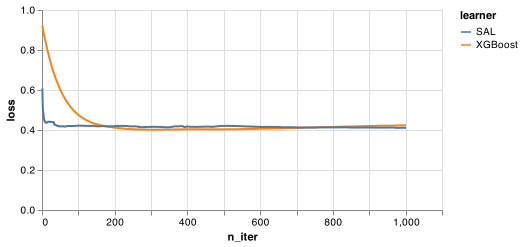

In [ ]:
df = vcat(df_xgb, df_sal);
df |>
@vlplot(
    :line,
    x=:n_iter,
    y=:loss,
    color=:learner,
    width=400,
    height=200
)

In [9]:
# import Distributions as Dist
# import LinearAlgebra: diagm

# n, p = 3000, 10

# X_dist = Dist.reshape(
#     Dist.MvNormal(zeros(p), 0.1ones(p,p) + 0.9diagm(ones(p))), 
#     (1,p)
# )
# ϵ_dist = Dist.Normal(0,1)

# X = vcat(rand(X_dist, n)...)
# ϵ = rand(ϵ_dist, n)

# Y = 5X[:,1] + X[:,2].^2 - 3X[:,3].*X[:,4] + ϵ
# Y = Y .- mean(Y)

# n_val = Int(round(n/2))
# X_val, Y_val = X[1:n_val,:], Y[1:n_val]
# X, Y = X[(n_val+1):end,:], Y[(n_val+1):end];